### Introduction

With this project, we aim to predict the outcome (win or loss) of college football games using a machine learning model. The selected dataset containins information about college football games played by 63 NCAA Division I Football Bowl Subdivision (FBS) teams, including features like the home team's rank, opponent's rank, attendance, weather conditions, stadium fill rate, and more. 

**Motivation:**

Accurately predicting the outcome of college football games is a challenging and interesting problem with various applications, such as:

* **Sports Analytics:** Gaining insights into the factors that contribute to winning games.
* **Fan Engagement:** Providing fans with predictions and probabilities to enhance their viewing experience.

This project focuses on building a predictive model by evaluating numerous ML models. We will explore various features and data preprocessing techniques to improve the model's accuracy.

### Ideas for New Features

While the current dataset provides a good foundation, there are several potential new features that could be explored to improve the model's predictive power:

* **Home Game vs. Bowl Game:** Distinguishing between regular season home games and bowl games could be important as bowl games often have different dynamics and higher stakes.
* **Rivalry Game and Championship Games:** Identifying rivalry games and conference championship games could capture the added intensity and significance of these matchups.
* **Temperature Differential for Road Team:** Considering the temperature difference between the home team's location and the road team's location might reveal how travel and climate affect performance.
* **Number of Points Scored by Offense in Season:** Incorporating the home team's offensive performance throughout the season could provide a more comprehensive view of their scoring ability.
* **Number of Points Allowed by Defense in Season:** Similarly, including the home team's defensive performance throughout the season could reflect their ability to prevent opponents from scoring.

These new features could potentially capture more nuanced aspects of the game and lead to a more accurate predictive model. We will implement a few of these (and more) later on in this notebook

### 1. Make necessary imports

In [152]:
# Feature exploration
import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

# Feature processing
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import re

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

### 2. Load dataset

In [153]:
df = pd.read_csv("cfb_dataset.csv", encoding="latin-1")
df = df.rename(columns={"Opponent_Rank": "Opponent Rank"})
df.head(5)

,Date,Team,Time,Opponent,Rank,Site,TV,Result,Attendance,Current Wins,...,PRCP,SNOW,SNWD,TMAX,TMIN,Opponent Rank,Conference,Year,Month,Day
0,9/2/2000,Arkansas,8:00 PM,Southwest Missouri State*,NR,"War Memorial StadiumLittle Rock, AR",Not on TV,W 38-0,53946,0,...,0.00,0.0,0.0,105,65,NR,SEC,2000,9,2
1,9/16/2000,Arkansas,6:00 PM,Boise State*,NR,"War Memorial StadiumLittle Rock, AR",Not on TV,W 38-31,54286,1,...,0.00,0.0,0.0,79,44,NR,SEC,2000,9,16
2,9/23/2000,Arkansas,8:00 PM,Alabama,NR,"Razorback StadiumFayetteville, AR",ESPN2,W 28-21,51482,2,...,2.12,0.0,0.0,85,63,NR,SEC,2000,9,23
3,9/30/2000,Arkansas,11:30 AM,No.-25 Georgia,NR,"Razorback StadiumFayetteville, AR",JPS,L 7-38,51162,3,...,0.00,0.0,0.0,77,45,25,SEC,2000,9,30
4,10/7/2000,Arkansas,6:00 PM,Louisiana-Monroe*,NR,"Razorback StadiumFayetteville, AR",Not on TV,W 52-6,50947,3,...,0.00,0.0,0.0,50,28,NR,SEC,2000,10,7


Feature explanations:
1. `Date`: MM/DD/YYYY of the game
2. `Team`: Name of the home team
3. `Time`: HH:MM of the game
4. `Opponent`: Name of the away team
5. `Rank`: Rank of the home team (based on the AP Poll)
6. `Site`: Stadium that hosts the game
7. `TV`: News channel that broadcasts the game
8. `Result`: Final score
9. `Attendance`: Number of fans in attendance
10. `Current Wins`: Number of wins the home team has this season before this game
11. `Current Losses`: Number of losses the home team has this season before this game
12. `Stadium Capacity`: Maximum possible fans in the stadium
13. `Fill Rate`: Attendance / Stadium Capacity
14. `New Coach`: Whether a first year head coach is coaching the home team
15. `Tailgating`: Whether Bleacher Report recognized the home team's school as a top 25 tailgating destination
16. `PRCP`: Precipitation during the game
17. `SNOW`: Snowfall during the game
18. `SNWD`: Snow depth during the game
19. `TMAX`: Maximum temperature during the game
20. `TMIN`: Minimum temperature during the game
21. `Opponent_Rank`: Rank of the away team (based on the AP Poll)
22. `Conference`: FBS Conference of the home team
23. `Year`: Year of the game
24. `Month`: Month of the game
25. `Day`: Day of the game

Note:
* Each game is only recorded ONCE from the HOME TEAM's perspective, 
  which we'll have to account for in feature engineering
* This dataset only contains 63 CFB schools and doesn't contain, say, Texas.
  However, this should not influence our modeling since the actual name
  of a school can be treated as more or less irrelevant
* This dataset also does not include playoff games (but includes rivalry games
  and conference championship games)

### 3. Data cleaning

Before we can perform data engineering and create new features, we must work on data cleaning. For instance, our dataset contains a lot of non-numerical columns that need to be converted into numerical formats for analysis and modeling.

#### I. Date processing

First, we convert the `Date` column into `datetime` date objects to help with sorting and processing in the futhre.

In [154]:
# Convert to datetime object for ease of processing
convert_datetime = lambda s: datetime.strptime(s, "%m/%d/%Y")
df["Date"] = df["Date"].apply(convert_datetime)

#### II. Target extraction

Then, we extract the win/loss label for each game, converting it to a binary variable (1 for win, 0 for loss). This is the **target** that our model will be attempting to predict. We can now also drop the **result** column from our dataframe.

In [155]:
# Drop invalid rows, 4355 resulted in Not Contest
df = df.drop(index=[4355])
# Not considering spring games
df = df[~df["Opponent"].str.contains("Spring Game")]

extract_result = lambda s: 1 if re.match(r"^(W|L)", s).group(1) == "W" else 0
df["Target"] = df["Result"].apply(extract_result)

# Extract points scored and points allowed for later feature engineering
df["Points Scored"] = df["Result"].apply(lambda s: int(s.split('-')[0].split()[1]))
df["Points Allowed"] = df["Result"].apply(lambda s: int(s.split('-')[1].split()[0]))

df = df.drop(columns=["Result"])

#### III. Opponent names and conferences
Here we process game data to clean opponent names and determine their conferences:
1. Clean opponent names by removing special characters, rankings (e.g. "No. 2"), and other symbols.
2. Match each opponent to their conference based on the year and team data from the dataset.
3. Add `Opponent Conference`: The conference for the opponent, or "N/A" if not found.
A limitation of this approach is that we can only impute the "Opponent_Conference" for opponents
that are also one of the 63 schools included in the dataset. However, this is sufficient for our
application.

In [156]:
# Function to clean opponent names
# Replaces non-breaking space characters with regular spaces and removes rankings (e.g., "No. 25")
def clean_opponent_name(name):
    name = name.replace("\xa0", " ")  # Replace non-breaking spaces with regular spaces
    return re.sub(r"No\.\s*\d+\s*", "", name).rstrip('*')  # Remove rankings and trailing asterisks

# Function to retrieve the opponent's conference based on the dataset
def get_opponent_conference(row, dataset):
    opponent = row["Opponent"]  # Extract opponent name from the current row
    year = row["Year"]  # Extract year from the current row
    # Filter dataset to find games played by the opponent in the same year
    opponent_games = dataset[(dataset["Team"] == opponent) & (dataset["Year"] == year)]
    
    if not opponent_games.empty:  # If opponent data exists in the dataset
        conference = opponent_games["Conference"].dropna().iloc[0]  # Get the first non-NA conference value
        return conference
    else:
        return "N/A"  # Return "N/A" if no data is found for the opponent

# Apply the cleaning function to the 'Opponent' column
df["Opponent"] = df["Opponent"].apply(clean_opponent_name)

# Apply the function to determine the opponent's conference for each row in the DataFrame
df["Opponent Conference"] = df.apply(get_opponent_conference, axis=1, args=(df,))

#### IV. Making rank numerical

Convert rank to a numerical value, "NR" or no ranking is represented with 26, which is one higher than the lowest possible ranking (25).

In [157]:
# Define a lambda function to convert rank values
# If the value is "NR" (Not Ranked), assign it a default rank of 26
# Otherwise, convert the rank to an integer
convert_rank = lambda v: int(v) if v != "NR" else 26

# Apply the conversion function to the 'Rank' column
df["Rank"] = df["Rank"].apply(convert_rank)

# Apply the same conversion function to the 'Opponent Rank' column
df["Opponent Rank"] = df["Opponent Rank"].apply(convert_rank)

#### V. Processing start times

Normalize the start times of the games. CFB games start between 10 AM and 9 PM. Using this information, we can normalize these times such that 0 represents a game starting at 10 AM and vice versa.

In [158]:
# Define a lambda function to convert time strings to datetime objects
convert_start_time = lambda t: datetime.strptime(t, "%I:%M %p")

# Apply the conversion function to the 'Time' column to transform all times into datetime objects
times = df["Time"].apply(convert_start_time)

# Define the minimum and maximum times for normalization
min_time, max_time = convert_start_time("10:00 AM"), convert_start_time("9:00 PM")

# Normalize the 'Time' column to a range of 0 to 1 based on min and max times
time_normalized = (times - min_time) / (max_time - min_time)

# Replace the original 'Time' column with the normalized values
df["Time"] = time_normalized

#### VI. Binary features

In [159]:
# Specify binary features to be converted to integers
binary_features = ["Tailgating", "New Coach"]

# Convert the specified binary features to integer type (0 or 1)
df[binary_features] = df[binary_features].astype(int)

### 4. Data exploration

#### I. Snowfall and snow depth

Considering the months during which college football games are usually played, snowfall is very rare. Knowing this, we immediately considered removing these attributes. As you can see below, the vast majority of values for `SNOW` and `SNWD` (snow depth) are indeed zeroes. Keeping these features is unlikely to be helpful for our model.

In [160]:
# Count and display the number of rows where 'SNOW' is greater than 0
print((df["SNOW"] > 0).value_counts(), end="\n\n")

# Count and display the number of rows where 'SNWD' (snow depth) is greater than 0
print((df["SNWD"] > 0).value_counts())

# Drop the 'SNOW' and 'SNWD' columns from the DataFrame as they are no longer needed
df = df.drop(columns=["SNOW", "SNWD"])

SNOW
False    6630
True       37
Name: count, dtype: int64

SNWD
False    6632
True       35
Name: count, dtype: int64


#### II. Target variable distribution

There are more wins than losses for the 63 teams in the dataset. This is because all games in the datasets are home games for these teams, and the included teams are on average above average in performance. However, this shouldn't be a huge issue given the data is not too imbalanced.

Note: we cannot generate records from the away team's perspective since we don't have all the relevant information (for instance, whether they have a new coach in a given year).

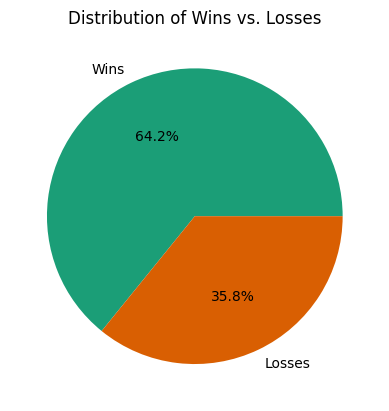

In [161]:
# Plot a pie chart showing the distribution of the 'Target' column (e.g., Wins vs. Losses)
df["Target"].value_counts().plot.pie(
    autopct="%1.1f%%",  # Display percentages with one decimal place
    labels=["Wins", "Losses"]  # Labels for the pie chart
)

# Add a title to the plot
plt.title("Distribution of Wins vs. Losses")

# Remove the y-axis label for cleaner visualization
plt.ylabel("")

# Display the pie chart
plt.show()

#### III. Correlation matrix

We want to use a correlation matrix to see which features are highly correlated (and thus redundant) or combined to make new features.

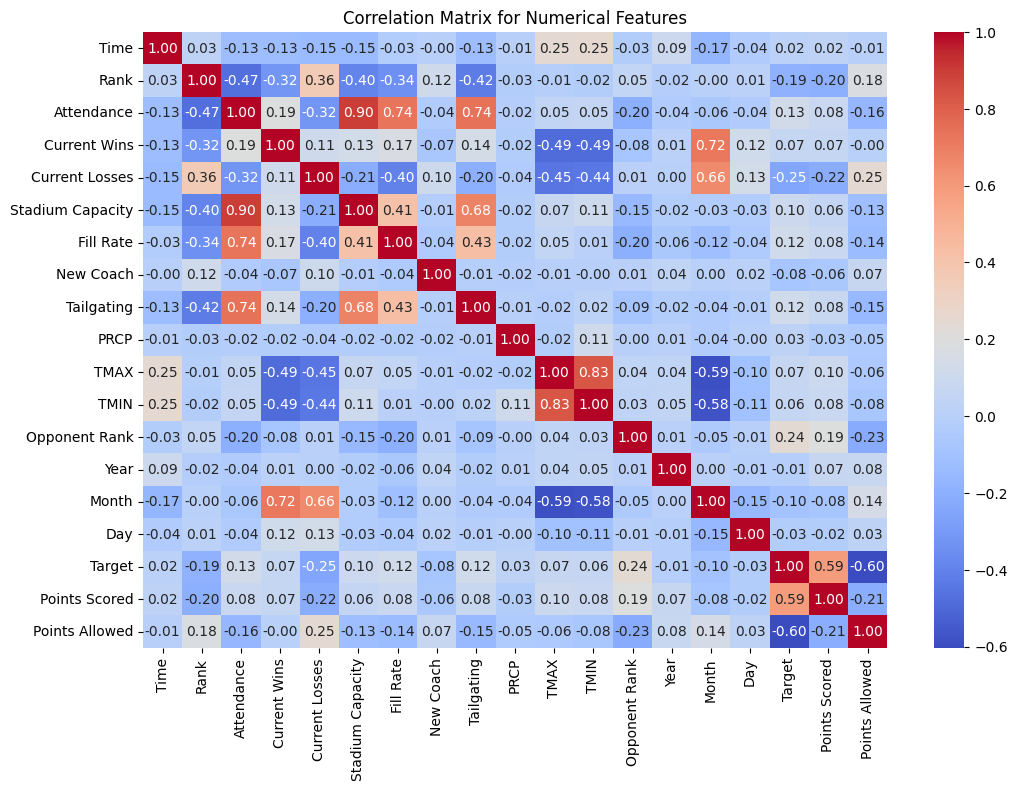

In [162]:
# Extract numerical features from the DataFrame to compute the correlation matrix
df_numerical = df.select_dtypes(include=[np.number])

# Create a figure for the heatmap
plt.figure(figsize=(12, 8))

# Compute the correlation matrix for numerical features
correlation_matrix = df_numerical.corr()

# Plot the correlation matrix as a heatmap with annotations and a color map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Add a title to the heatmap
plt.title('Correlation Matrix for Numerical Features')

# Display the heatmap
plt.show()

**Observations**
- `Tailgating` has a strong positive correlation with `Attendance` and `Fill Rate`, indicating schools that are better at tailgating also love to fill their stadiums and show up in large numbers. It has a moderate negative correlation with `Rank`, indicating schools that are better at tailgating are more likely to have better ranks (lower rank number, hence the negative).
- `Stadium Capacity`, `Attendance`, and `Fill Rate` all have a moderate negative correlation with `Rank`, which indicates how more fan presence can improve rank.
- `Current Wins` has a moderate negative correlation with `Rank` while `Current Losses` has a moderate positive correlation with `Rank`, showing how a better season record (more wins than losses) leads to a better rank.

**Potential actions**
- There is a very strong positive correlation between `Attendance` and `Stadium Capacity` (which makes sense because a bigger stadium allows for more fans to attend), **so we can likely drop one of these features (like `Stadium Capacity`) as they convey the same information.**
- There is a strong positive correlation between `Current Wins`, `Current Losses` and `Month`, as more wins/losses accumulate as the months go by. There is a moderately strong negative correlation between `TMIN`, `TMAX` and `Month`, as the temperature gets colder as the months go by. These two observations help explain the moderate negative correlation between `Current Wins`, `Current Losses` and `TMIN`, `TMAX`, as temperatures drop as the season progresses and wins/losses grow. **These observations support the idea of creating two features, one for win/loss ratio (model would understand this better as it doesn't just accumulate throughout the season and can actually reflect performance) and one for season progression (like number of games played, which would more accurately convey the information that month conveys).**
- `TMIN` and `TMAX` have a very strong positive correlation with one another, as they can convey similar information about the temperature. **We can replace these two features with average temperature ((`TMIN` + `TMAX`) / 2) to group the two similar features in one.**

**Additional comments**
- `Year` and `Day` have very little correlation with `Target`, **so we can likely drop these later on.**
- `PRCP` and `New Coach` have little correlation with `Target`, but we may not want to drop these for now as logically they could have an impact.

#### IV. Add `Win Ratio` and `Games Played`

In [163]:
# Calculate the win ratio for each row as the ratio of current wins to total games played
df['Win Ratio'] = df['Current Wins'] / (df['Current Wins'] + df['Current Losses'])

# Calculate the total number of games played (in the data, as some games in a season are not recorded)
df['Games Played'] = df.groupby(['Team', 'Year']).cumcount()

# Replace any NaN values in the 'Win Ratio' column with 0 (e.g., for rows where no games have been played)
df["Win Ratio"] = df['Win Ratio'].fillna(0)

#### V. Add `Average Temperature`

In [164]:
# Calculate the average temperature as the mean of TMIN and TMAX
df['Average Temperature'] = (df['TMIN'] + df['TMAX']) / 2

#### VI. Drop discussed featrues

In [165]:
to_drop = [
    "Stadium Capacity",
    "Current Wins", "Current Losses",
    "TMIN", "TMAX",
]
df = df.drop(columns=to_drop)

#### VII. Conference

A school's conference has a huge impact in college football, some conferences
(e.g. SEC) have been historical football strongholds, whereas others (e.g. AAC,
Pac-12) often struggle with out-of-conference games.

After calculating the win rates grouped by conference, we can see that the rates
vary widely. Interestingly FCS (the second tier of D1 football) and WAC (the Western
Athletic Conference, inactive from 2013 to 2020) have the highest win rates. This
might be because that there is only a small sample size of FCS school games, and
WAC schools play few strong out of conference opponents by design of the conference.

Hence, we'll be keeping `Conference` as a feature.

FCS games count: 91


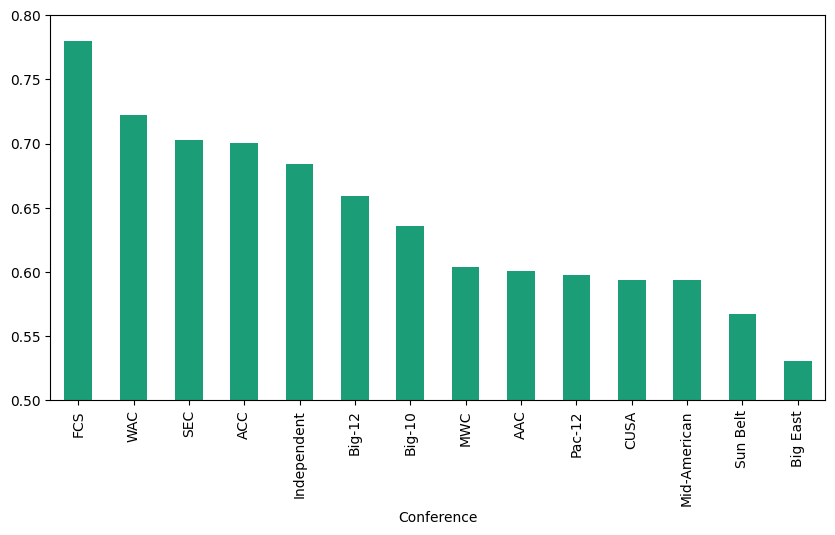

In [166]:
# Count the number of games where the conference is "FCS"
print("FCS games count:", len(df[df["Conference"] == "FCS"]))

# Calculate the mean of the 'Target' column grouped by 'Conference', and sort in descending order
stats = df.groupby("Conference")["Target"].mean().sort_values(ascending=False)

# Plot the mean 'Target' values for each conference as a bar chart
plt.figure(figsize=(10, 5))  # Set figure size
stats.plot(kind="bar")  # Create a bar plot
plt.ylim([0.5, 0.8])  # Set y-axis limits to focus on relevant range
plt.show()  # Display the plot

#### VIII. Add `Average Points Scored` and `Average Points Allowed`
These two values are commonly used in sports analytics and give us a general gauge of the strength of a team's offense vs. defense up to that point in its season. A possible issue is that for a team's first game in a season, their average points score and allowed will always be zero. However, the same is generally true for their opponent at that point in the season, and these cases represent a very small portion of the dataset. Since CFB team strengths vary widely from season to season (e.g. Michigan, the national championships from 2023, is not doing well in 2024), trying to impute these values based on past season data might not be very effective either. Plus, we don't always have access to that data in our dataset. Therefore, we are opting to keep these values at zero. 

In [167]:
# Group the DataFrame by 'Team' and 'Year'
grouped = df.groupby(['Team', 'Year'])

# Calculate cumulative sum of 'Points Scored' and 'Points Allowed' for each group, shift by 1 to exclude the current game, and reset index to align with df
df["Points Scored"] = grouped['Points Scored'].apply(lambda x: x.cumsum().shift(1, fill_value=0)).reset_index(level=['Team', 'Year'], drop=True)
df["Points Allowed"] = grouped['Points Allowed'].apply(lambda x: x.cumsum().shift(1, fill_value=0)).reset_index(level=['Team', 'Year'], drop=True)

# Calculate the average points scored and allowed by dividing the cumulative sum by the number of games played
games_played = df["Games Played"].replace(to_replace=0, value=1)
df["Average Points Scored"] = df["Points Scored"] / games_played
df["Average Points Allowed"] = df["Points Allowed"] / games_played

df.head()

,Date,Team,Time,Opponent,Rank,Site,TV,Attendance,Fill Rate,New Coach,...,Day,Target,Points Scored,Points Allowed,Opponent Conference,Win Ratio,Games Played,Average Temperature,Average Points Scored,Average Points Allowed
0,2000-09-02,Arkansas,0.909091,Southwest Missouri State,26,"War Memorial StadiumLittle Rock, AR",Not on TV,53946,1.004076,0,...,2,1,0,0,N/A,0.00,0,85.0,0.000000,0.000000
1,2000-09-16,Arkansas,0.727273,Boise State,26,"War Memorial StadiumLittle Rock, AR",Not on TV,54286,1.010404,0,...,16,1,38,0,WAC,1.00,1,61.5,38.000000,0.000000
2,2000-09-23,Arkansas,0.909091,Alabama,26,"Razorback StadiumFayetteville, AR",ESPN2,51482,1.029249,0,...,23,1,76,31,SEC,1.00,2,74.0,38.000000,15.500000
3,2000-09-30,Arkansas,0.136364,No.-25 Georgia,26,"Razorback StadiumFayetteville, AR",JPS,51162,1.022851,0,...,30,0,104,52,N/A,1.00,3,61.0,34.666667,17.333333
4,2000-10-07,Arkansas,0.727273,Louisiana-Monroe,26,"Razorback StadiumFayetteville, AR",Not on TV,50947,1.018553,0,...,7,1,111,90,N/A,0.75,4,39.0,27.750000,22.500000


#### IX. Drop unecessary columns

In [48]:
"""
The actually team names should be generally irrelevant in win prediction
"""
to_drop = [
    "Team", "Opponent",
    "Site", 
    "Date", "Year", "Month",
    "TV",
    "Day",
    "Points Scored",
    "Points Allowed"
]
df = df.drop(columns=to_drop)

#### X. One hot encode `Conference` and `Opponent Conference`

We will one hot encode `Conference` so that it can be represented as a numerical value in training. For `Opponent Conference`, we want to handle the great number of N/A values and the generally low number of known conferences. We will separate opponent conferences into four groups: Power 5, Same Conference (as home team), Non-Power 5, N/A. This will help extract the most useful information (for example, games between two teams of the same conference can have more importance, and there is usually a drastic strength difference between Power 5 and Non-Power 5 teams).

In [ ]:
# Define the set of Power 5 conferences
power_5 = {'SEC', 'Big-10', 'Big-12', 'ACC', 'Pac-12'}

# Function to classify the opponent's conference category
def classify_conference(team_conf, opp_conf):
    if team_conf == opp_conf:  # Same conference as the team
        return 'Same Conference'
    elif opp_conf in power_5:  # Opponent is in a Power 5 conference
        return 'Power 5'
    elif opp_conf is None:  # Missing or undefined opponent conference
        return 'N/A'
    else:  # Opponent is in a Non-Power 5 conference
        return 'Non-Power 5'

# Apply the classification function to create a new column
df['Opponent Conference Category'] = df.apply(
    lambda row: classify_conference(row['Conference'], row['Opponent Conference']),
    axis=1
)

# One-hot encode the team's home conference and opponent's conference category
home_one_hot = pd.get_dummies(df['Conference'], prefix='Home Conference').astype(int)
opponent_one_hot = pd.get_dummies(df['Opponent Conference Category'], prefix='Opponent Conference').astype(int)

# Concatenate the one-hot encoded columns with the original DataFrame
df = pd.concat([df, home_one_hot, opponent_one_hot], axis=1)

# Drop the original categorical columns as they are now encoded
df = df.drop(columns=["Conference", "Opponent Conference", "Opponent Conference Category"])

# Display the first few rows of the updated DataFrame
df.head()

,Time,Rank,Attendance,Fill Rate,New Coach,Tailgating,PRCP,Opponent Rank,Target,Win Ratio,...,Home Conference_Independent,Home Conference_MWC,Home Conference_Mid-American,Home Conference_Pac-12,Home Conference_SEC,Home Conference_Sun Belt,Home Conference_WAC,Opponent Conference_Non-Power 5,Opponent Conference_Power 5,Opponent Conference_Same Conference
0,0.909091,26,53946,1.004076,0,0,0.00,26,1,0.00,...,0,0,0,0,1,0,0,1,0,0
1,0.727273,26,54286,1.010404,0,0,0.00,26,1,1.00,...,0,0,0,0,1,0,0,1,0,0
2,0.909091,26,51482,1.029249,0,0,2.12,26,1,1.00,...,0,0,0,0,1,0,0,0,0,1
3,0.136364,26,51162,1.022851,0,0,0.00,25,0,1.00,...,0,0,0,0,1,0,0,1,0,0
4,0.727273,26,50947,1.018553,0,0,0.00,26,1,0.75,...,0,0,0,0,1,0,0,1,0,0


#### XI. Normalize continuous features using StandardScaler

In [168]:
# Initialize a StandardScaler to standardize continuous features
scaler = StandardScaler()

# List of continuous features to be scaled
continuous_features = [
    'Time', 'Rank', 'Attendance', 'Fill Rate', 
    'PRCP', 'Average Temperature', 'Win Ratio', 'Games Played'
]

# Apply scaling to the specified continuous features in the DataFrame
df[continuous_features] = scaler.fit_transform(df[continuous_features])

# Display the first few rows of the scaled DataFrame
df.head()

,Date,Team,Time,Opponent,Rank,Site,TV,Attendance,Fill Rate,New Coach,...,Day,Target,Points Scored,Points Allowed,Opponent Conference,Win Ratio,Games Played,Average Temperature,Average Points Scored,Average Points Allowed
0,2000-09-02,Arkansas,1.531297,Southwest Missouri State,0.44132,"War Memorial StadiumLittle Rock, AR",Not on TV,0.342211,0.948179,0,...,2,1,0,0,N/A,-1.517671,-1.408801,1.750255,0.000000,0.000000
1,2000-09-16,Arkansas,0.832755,Boise State,0.44132,"War Memorial StadiumLittle Rock, AR",Not on TV,0.355719,0.976773,0,...,16,1,38,0,WAC,1.478125,-0.863329,0.033852,38.000000,0.000000
2,2000-09-23,Arkansas,1.531297,Alabama,0.44132,"Razorback StadiumFayetteville, AR",ESPN2,0.244316,1.061922,0,...,23,1,76,31,SEC,1.478125,-0.317858,0.946832,38.000000,15.500000
3,2000-09-30,Arkansas,-1.437507,No.-25 Georgia,0.44132,"Razorback StadiumFayetteville, AR",JPS,0.231603,1.033015,0,...,30,0,104,52,N/A,1.478125,0.227614,-0.002668,34.666667,17.333333
4,2000-10-07,Arkansas,0.832755,Louisiana-Monroe,0.44132,"Razorback StadiumFayetteville, AR",Not on TV,0.223061,1.013593,0,...,7,1,111,90,N/A,0.729176,0.773085,-1.609513,27.750000,22.500000


### 5. Modeling

#### I. Decision Tree
First we will attempt to model this dataset using a decision tree. We will use nested cross validation testing across various hyperparameters to identify an optimal decision tree solution.

In [169]:
# Initialize a Decision Tree Classifier with entropy criterion
clf = DecisionTreeClassifier(criterion="entropy")

# Define hyperparameter grid for tuning
params = {
    "max_depth": [5, 10, 15, 20, 25],  # Test different tree depths
    "max_features": list(range(1, 30, 5)),  # Test different numbers of features to consider at each split
    "min_samples_leaf": list(range(1, 25, 5))  # Test different minimum samples required in a leaf node
}

# Split features and target variable from the dataset
data_X, data_Y = df.drop(columns=["Target"]), df["Target"]

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')

# Generate cross-validated predictions for the entire dataset
pred_labels = cross_val_predict(grid_search, data_X, data_Y, cv=5)

# Calculate and print overall accuracy
accuracy = accuracy_score(data_Y, pred_labels)
print("Accuracy:", accuracy)

# Print detailed classification metrics (precision, recall, F1-score)
print(classification_report(data_Y, pred_labels))

ValueError: 
All the 750 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
750 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 1009, in fit
    super()._fit(
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 252, in _fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 645, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: float() argument must be a string or a real number, not 'Timestamp'


#### II. Naive Bayes

Next, we attempt to classify using the Gaussian Naive Bayes algorithm.

In [ ]:
# Initialize Gaussian Naive Bayes classifier
clf = GaussianNB()

# Perform 10-fold cross-validation and generate predictions
pred_labels = cross_val_predict(clf, data_X, data_Y, cv=10)

# Calculate and print accuracy
print("Accuracy:", accuracy_score(data_Y, pred_labels))

# Print detailed classification report
print(classification_report(data_Y, pred_labels))

Accuracy: 0.5446227688615569
              precision    recall  f1-score   support

           0       0.40      0.55      0.46      2390
           1       0.68      0.54      0.60      4277

    accuracy                           0.54      6667
   macro avg       0.54      0.55      0.53      6667
weighted avg       0.58      0.54      0.55      6667



#### III. KNN

Next, we use the KNN algorithm. For this model, we perform data data scaling and dimensionality reduction to handle issues with using Euclidean distance as our metric. Our hyperparameters are the number of dimensions we reduce down to and the number of neighbors we use.

In [ ]:
# Create a pipeline with scaling, PCA, and KNN classifier
scaler = StandardScaler()
pca = PCA()
clf = KNeighborsClassifier()
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("knn", clf)])

# Define hyperparameter grid for PCA and KNN
params = {
    'pca__n_components': list(range(5, 20, 3)),  # Number of PCA components to test
    'knn__n_neighbors': list(range(1, 20, 3))    # Number of neighbors for KNN to test
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipe, params, cv=5)

# Generate cross-validated predictions
pred_labels = cross_val_predict(grid_search, data_X, data_Y, cv=5)

# Calculate and print accuracy and classification report
accuracy = accuracy_score(data_Y, pred_labels)
print("Accuracy:", accuracy)
print(classification_report(data_Y, pred_labels))

Accuracy: 0.6490175491225438
              precision    recall  f1-score   support

           0       0.52      0.29      0.37      2390
           1       0.68      0.85      0.76      4277

    accuracy                           0.65      6667
   macro avg       0.60      0.57      0.57      6667
weighted avg       0.62      0.65      0.62      6667



#### IV. SVM

Next, we use a SVM model and again perform data scaling and dimensionality reduction. The hyperparameters here are the kernel and the number of dimensions used.

In [170]:
# Create a pipeline with scaling, PCA, and SVM
scaler = StandardScaler()
pca = PCA()
clf = SVC()
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("svm", clf)])

# Define hyperparameter grid for PCA and SVM
params = {
    'pca__n_components': list(range(5, 20, 3)),  # Number of principal components to test
    'svm__kernel': ['linear', 'rbf', 'poly'],    # SVM kernel types to test
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipe, params, cv=5)

# Generate cross-validated predictions
pred_labels = cross_val_predict(grid_search, data_X, data_Y, cv=5)

# Calculate and print accuracy and classification report
accuracy = accuracy_score(data_Y, pred_labels)
print("Accuracy:", accuracy)
print(classification_report(data_Y, pred_labels))

ValueError: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py", line 878, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py", line 914, in partial_fit
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: float() argument must be a string or a real number, not 'Timestamp'


#### V. Neural Net

Next, we try using a Neural Net and perform data scaling. The hyperparameters we are adjusting are the hidden layer size and the activation function used.

In [ ]:
clf = MLPClassifier()
scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("mlp", clf)])

# Define hyperparameter grid for tuning
params = {
    'mlp__hidden_layer_sizes': [(40,), (50,), (60,), (70,)],
    'mlp__activation': ['logistic', 'tanh', 'relu'],
    'mlp__early_stopping': [True],
    'mlp__validation_fraction': [0.1],
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipe, params, cv=5)

# Generate cross-validated predictions
pred_labels = cross_val_predict(grid_search, data_X, data_Y, cv=5)

# Calculate and print accuracy and classification report
accuracy = accuracy_score(data_Y, pred_labels)
print("Accuracy:", accuracy)
print(classification_report(data_Y, pred_labels))

Accuracy: 0.6707664616769161
              precision    recall  f1-score   support

           0       0.57      0.35      0.43      2390
           1       0.70      0.85      0.77      4277

    accuracy                           0.67      6667
   macro avg       0.63      0.60      0.60      6667
weighted avg       0.65      0.67      0.65      6667



#### VI. Random Forest

Now, we will begin to try using ensemble methods. First, we use the Random Forest model.

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

# Initialize RandomForestClassifier
clf = RandomForestClassifier()

# Define hyperparameter grid
params = {
    'max_depth': list(range(5, 26, 5)),  # Test max_depth values from 5 to 25
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(clf, params, cv=5)

# Generate cross-validated predictions
pred_labels = cross_val_predict(grid_search, data_X, data_Y, cv=5)

# Calculate and print accuracy
accuracy = accuracy_score(data_Y, pred_labels)
print("Accuracy:", accuracy)

# Print detailed classification metrics
print(classification_report(data_Y, pred_labels))

ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: float() argument must be a string or a real number, not 'Timestamp'


#### VII. AdaBoost

Finally, we try the AdaBoost classifier on our data.

In [172]:
clf = AdaBoostClassifier()

params = {
    'n_estimators': list(range(50, 200, 50))
}

grid_search = GridSearchCV(clf, params, cv=5)

pred_labels = cross_val_predict(grid_search, data_X, data_Y, cv=5)
accuracy = accuracy_score(data_Y, pred_labels)

print("Accuracy:", accuracy)
print(classification_report(data_Y, pred_labels))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py", line 169, in fit
    sample_weight, estimator_weight, estimator_error = self._boost(
                                                       ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py", line 594, in _boost
    return self._boost_real(iboost, X, y, sample_weight, random_state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py", line 605, in _boost_real
    estimator.fit(X, y, sample_weight=sample_weight)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 1009, in fit
    super()._fit(
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 252, in _fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 645, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: float() argument must be a string or a real number, not 'Timestamp'


#### VIII. Final Model

We see that the decision tree has higher accuracy and F-score than the other models, so we will use that as our final model.

In [173]:
import pickle

# Prepare the data
data_X, data_Y = df.drop(columns=["Target"]), df["Target"]

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(criterion="entropy")

# Define the hyperparameters for grid search
params = {
    "max_depth": [5, 10, 15, 20, 25],
    "max_features": list(range(1, 30, 5)),
    "min_samples_leaf": list(range(1, 25, 5)),
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
grid_search.fit(data_X, data_Y)

# Get the best model and parameters
final_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Save the final model to a file 
filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

ValueError: 
All the 750 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
750 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 1009, in fit
    super()._fit(
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 252, in _fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 645, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: float() argument must be a string or a real number, not 'Timestamp'


We will test finalized_model.sav using nested cross-validation.

In [ ]:
from sklearn.model_selection import KFold

# Load the final model from the saved file
final_model = pickle.load(open('finalized_model.sav', 'rb'))

# Define the outer and inner cross-validation strategies
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

outer_scores = []

# Perform nested cross-validation
for train_index, test_index in outer_cv.split(data_X, data_Y):
    # Split the data into training and testing sets
    X_train, X_test = data_X.iloc[train_index], data_X.iloc[test_index]
    y_train, y_test = data_Y.iloc[train_index], data_Y.iloc[test_index]

    # Define the model and hyperparameters for grid search
    clf = DecisionTreeClassifier(criterion="entropy")
    params = {
        "max_depth": [5, 10, 15, 20, 25],
        "max_features": list(range(1, 30, 5)),
        "min_samples_leaf": list(range(1, 25, 5)),
    }
    
    # Perform grid search with inner cross-validation
    grid_search = GridSearchCV(clf, params, cv=inner_cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the outer test set
    score = best_model.score(X_test, y_test)
    outer_scores.append(score)

# Print the nested cross-validation scores and average accuracy
print("Nested cross-validation scores:", outer_scores)
print("Average accuracy:", np.mean(outer_scores))

Nested cross-validation scores: [0.6859070464767616, 0.7016491754122939, 0.7014253563390848, 0.6984246061515379, 0.687171792948237]
Average accuracy: 0.6949155954655831
